In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

## MNIST

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    "mnist",
    split = ["train", "test"], # Some datasets have "validation" too
    shuffle_files = True,
    as_supervised=True, #(image, label)
    with_info=True
)

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

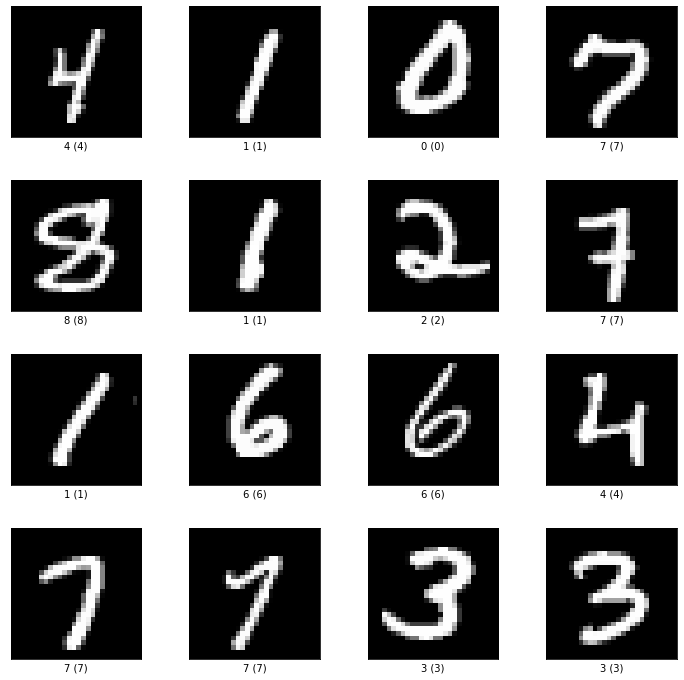

In [ ]:
fig = tfds.show_examples(ds_train, ds_info, rows=4, cols=4)

In [ ]:
def nornalize_img(img, label):
  '''
  Normalize images
  '''
  return tf.cast(img, tf.float32)/255.0, label

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

ds_train = ds_train.map(nornalize_img, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)

ds_test = ds_test.map(nornalize_img, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.prefetch(AUTOTUNE)


In [ ]:
model = keras.Sequential(
    [
     keras.Input(shape=(28,28,1)),
     layers.Conv2D(32,3,activation='relu'),
     layers.Flatten(),
     layers.Dense(10)
    ]
)

model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [ ]:
model.fit(ds_train, epochs=5, verbose = 2)

Epoch 1/5
938/938 - 17s - loss: 0.2032 - accuracy: 0.9422 - 17s/epoch - 18ms/step
Epoch 2/5
938/938 - 2s - loss: 0.0727 - accuracy: 0.9785 - 2s/epoch - 2ms/step
Epoch 3/5
938/938 - 2s - loss: 0.0512 - accuracy: 0.9851 - 2s/epoch - 2ms/step
Epoch 4/5
938/938 - 2s - loss: 0.0393 - accuracy: 0.9880 - 2s/epoch - 2ms/step
Epoch 5/5
938/938 - 2s - loss: 0.0310 - accuracy: 0.9907 - 2s/epoch - 2ms/step


In [ ]:
model.evaluate(ds_test, verbose = 2)

157/157 - 1s - loss: 0.0594 - accuracy: 0.9813 - 1s/epoch - 7ms/step


[0.05944066122174263, 0.9812999963760376]

## IMDB - Dataset Reviews

In [ ]:
(ds_train, ds_test), ds_info =tfds.load(
    "imdb_reviews",
    split = ["train", "test"],
    shuffle_files = True,
    as_supervised = True,
    with_info = True
)

print(ds_info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

In [ ]:
# Tokenizing this dataset
tokenizer = tfds.deprecated.text.Tokenizer()

In [ ]:
def build_vocab():
  vocab = set()
  for text,_ in ds_train:
    vocab.update(tokenizer.tokenize(text.numpy().lower()))
  return vocab

In [ ]:
vocab = build_vocab()

In [ ]:
encoder = tfds.deprecated.text.TokenTextEncoder(
    vocab,
    oov_token = "<UNK>",
    lowercase=True,
    tokenizer = tokenizer
)

In [ ]:
def my_encoding(text_tensor, label):
  return encoder.encode(text_tensor.numpy()), label

In [ ]:
def encode_map(text, label):
  encoded_text, label = tf.py_function(
      my_encoding,
      inp = [text, label],
      Tout = (tf.int64, tf.int64)
  )

  encoded_text.set_shape([None])
  label.set_shape([])

  return encoded_text, label

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = ds_train.map(encode_map, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.shuffle(10000)
ds_train = ds_train.padded_batch(32, padded_shapes=([None], ()))
ds_train = ds_train.prefetch(AUTOTUNE)
ds_train = ds_train.cache()

ds_test = ds_test.map(encode_map, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.padded_batch(32, padded_shapes=([None], ()))



In [ ]:
model = keras.Sequential(
    [
     layers.Masking(mask_value=0),
     layers.Embedding(input_dim=len(vocab)+2, output_dim = 64),
    #  layers.LSTM(64, activation='sigmoid'),
     layers.GlobalAveragePooling1D(),
     layers.Dense(64, activation = 'relu'),
     layers.Dense(1)
    ]
)

model.compile(
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(3e-4, clipnorm=1),
    metrics = ["accuracy"]
)

In [ ]:
model.fit(ds_train, epochs = 5, verbose = 2)

Epoch 1/5
782/782 - 4s - loss: 0.6550 - accuracy: 0.5350 - 4s/epoch - 5ms/step
Epoch 2/5
782/782 - 4s - loss: 0.4234 - accuracy: 0.7972 - 4s/epoch - 4ms/step
Epoch 3/5
782/782 - 4s - loss: 0.2922 - accuracy: 0.8808 - 4s/epoch - 5ms/step
Epoch 4/5
782/782 - 4s - loss: 0.2350 - accuracy: 0.9076 - 4s/epoch - 5ms/step
Epoch 5/5
782/782 - 4s - loss: 0.1972 - accuracy: 0.9248 - 4s/epoch - 4ms/step


In [ ]:
model.evaluate(ds_test, verbose = 2)

782/782 - 21s - loss: 0.2913 - accuracy: 0.8660 - 21s/epoch - 27ms/step


[0.29130709171295166, 0.8659600019454956]

In [ ]:
model.layers[1].weights[0].numpy().shape

(74895, 64)

# CIFAR-10
Augmentation

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    "cifar10",
    split = ["train", "test"],
    shuffle_files = True,
    as_supervised = True,
    with_info = True
)

In [ ]:
def normalize_image(img, label):
  return tf.cast(img, tf.float32)/255.0, label

In [ ]:
from tensorflow.python.ops.image_ops_impl import random_flip_left_right
def augment(image, label):
  new_height = new_width = 32
  image = tf.image.resize(image, (new_height, new_width))

  # Grayscale - probabalistic

  if tf.random.uniform((), minval=0, maxval=1) < 0.1:
    image = tf.tile(tf.image.rgb_to_grayscale(image), [1,1,3])
  
  image = tf.image.random_brightness(image, max_delta = 0.1)
  image = tf.image.random_contrast(image, lower = 0.1, upper =0.2)

  # Flipping - Careful, don't destroy label
  image = tf.image.random_flip_left_right(image) #50%
  # image = tf.image.random.flip_up_down(image) #50%

  return image, label

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

In [ ]:
ds_train = ds_train.map(normalize_image, num_parallel_calls=AUTO).cache().shuffle(ds_info.splits["train"].num_examples)
ds_train = ds_train.map(augment, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)
ds_test = ds_test.map(normalize_image, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)

In [ ]:
ds_train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
class CNNBlock(layers.Layer):
  def __init__(self, channels):
    super().__init__()
    self.cnn = layers.Conv2D(channels, 3, padding='same', activation='leaky_relu', kernel_regularizer=keras.regularizers.l2(0.001))
    self.batchNorm = layers.BatchNormalization()
    # self.pool = layers.MaxPooling2D()
  
  def call(self, x, training = False):
    x = self.cnn(x)
    x = self.batchNorm(x)
    return tf.nn.relu(x)

class resBlock(layers.Layer):
  def __init__(self, channels):
    super().__init__()
    self.cnn1 = CNNBlock(channels[0])
    self.cnn2 = CNNBlock(channels[1])
    self.cnn3 = CNNBlock(channels[2])
    self.pool = layers.MaxPooling2D()
    self.identity_map = layers.Conv2D(channels[1], 1)
  
  def call(self, x, training = False):
    out = self.cnn1(x, training=training)
    out = self.cnn2(out, training=training)
    out = self.cnn3(self.identity_map(x) + out, training=training)
    return self.pool(out)

In [ ]:
layer = resBlock(channels=[32,32,64])

In [ ]:
class ResNet_lite(keras.Model):
  def __init__(self, num_classes=10):
    super().__init__()
    self.b1 = resBlock(channels=[32,32,64])
    self.b2 = resBlock(channels=[64,64, 128])
    self.b3 = resBlock(channels=[128,256,256])
    self.pool = layers.GlobalAveragePooling2D()
    self.ff = [
         layers.Flatten(),
         layers.Dense(64, activation='relu'),
         layers.Dense(10, activation = 'softmax')
        ]
  
  def call(self, x, training = False):
    x = self.b1(x, training)
    x = self.b2(x, training)
    x = self.b3(x, training)
    x = self.pool(x)
    for f in self.ff:
      x = f(x)
    
    return x


In [ ]:
model = keras.Sequential([
    keras.Input(shape=(32, 32,3)),
    
    resBlock([32,32,64]),
    resBlock([64, 128, 128]),
    resBlock([128, 256, 256]),

    layers.Flatten(),
    layers.Dense(64, activation = "leaky_relu"),
    layers.Dropout(0.3),
    layers.Dense(10)
])

# model = keras.Sequential([
#     keras.Input(shape=(32,32,3)),
#     ResNet_lite(10)
# ])
model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(3e-4),
    metrics = ["accuracy"]
)

In [ ]:
model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(3e-4, amsgrad=True),
    metrics = ["accuracy"]
)

In [ ]:
model.fit(ds_train, epochs=30, verbose=2)

Epoch 1/30
1563/1563 - 21s - loss: 2.7818 - accuracy: 0.2973 - 21s/epoch - 14ms/step
Epoch 2/30
1563/1563 - 18s - loss: 1.8234 - accuracy: 0.5753 - 18s/epoch - 12ms/step
Epoch 3/30
1563/1563 - 18s - loss: 1.3661 - accuracy: 0.6961 - 18s/epoch - 11ms/step
Epoch 4/30
1563/1563 - 18s - loss: 1.1600 - accuracy: 0.7477 - 18s/epoch - 12ms/step
Epoch 5/30
1563/1563 - 18s - loss: 1.0244 - accuracy: 0.7849 - 18s/epoch - 12ms/step
Epoch 6/30
1563/1563 - 18s - loss: 0.9465 - accuracy: 0.8027 - 18s/epoch - 11ms/step
Epoch 7/30
1563/1563 - 18s - loss: 0.8793 - accuracy: 0.8240 - 18s/epoch - 11ms/step
Epoch 8/30
1563/1563 - 18s - loss: 0.8361 - accuracy: 0.8373 - 18s/epoch - 11ms/step
Epoch 9/30
1563/1563 - 18s - loss: 0.8095 - accuracy: 0.8463 - 18s/epoch - 11ms/step
Epoch 10/30
1563/1563 - 18s - loss: 0.7794 - accuracy: 0.8566 - 18s/epoch - 12ms/step
Epoch 11/30
1563/1563 - 18s - loss: 0.7591 - accuracy: 0.8630 - 18s/epoch - 12ms/step
Epoch 12/30
1563/1563 - 18s - loss: 0.7406 - accuracy: 0.8720 -

In [ ]:
model.evaluate(ds_test, verbose = 2)

313/313 - 2s - loss: 1.4053 - accuracy: 0.7334 - 2s/epoch - 6ms/step


[1.4052510261535645, 0.7333999872207642]